In [1]:
import json
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = []
for filename in glob('../results/2D*.json'):
    with open(filename, 'r') as f:
        data += json.load(f)

data = [o for o in data if len(o['times'])!=0 and not o['error']]

In [3]:
def calc_gflops(N, time, type):
    if type == 'ss':
        return 2*(N**3) / time / (10**9)
    elif type == 'ts' or type == 'st':
        return (N**3) / time / (10**9)
    elif type == 'tt':
        return (N**3) / time / (10**9) / 3
    else:
        return -100

In [4]:
type_map = {'SS_MKL':1, 'TS_MKL':2, 'TT_MKL':3}

def load_mkl_data(results_file_glob):
    mkl_data = []
    for filename in glob(results_file_glob):
        with open(filename, 'r') as f:
            mkl_data += json.load(f)

    X, Y = [], []
    for m in mkl_data:
        type = m['command'].split('/')[-1].split(' ')[0]
        X.append([m['N'], m['num_threads'], type_map[type], None])
        Y.append(np.mean(sorted(m['times'])[1:-1]))

    X = np.array(X)
    Y = np.array(Y)
    Y.shape = (Y.shape[0], 1)
    M = np.hstack([X,Y])
    return M


def plot_mkl(M, time=False, num_threads=6, title=None):
    X = np.unique(M[:,0])
    for type in ['SS_MKL', 'TT_MKL']:
        Y = []
        for N in X:
            m = M[np.where(M[:,0]==N)]              # N
            m = m[np.where(m[:,1]==num_threads)]    # num_threads
            m = m[np.where(m[:,2]==type_map[type])] # 'SS' or 'TT'
            t = m[np.where(m[:,4]==np.min(m[:,4]))][0][4]
            if type == 'SS_MKL':
                gflops = calc_gflops(N, t, 'ss')
            elif type == 'TT_MKL':
                gflops = calc_gflops(N, t, 'ts')
            Y.append(t if time else gflops)
        plt.plot(X, Y, 'o-', linewidth=2, label='cblas_sgemm' if type=='SS_MKL' else 'cblas_strmm')
    if title:
        plt.title(title)
    plt.xlabel('Problem size (N)')
    plt.ylabel('Time (sec)' if time else 'GFLOPs/sec')
    plt.legend()

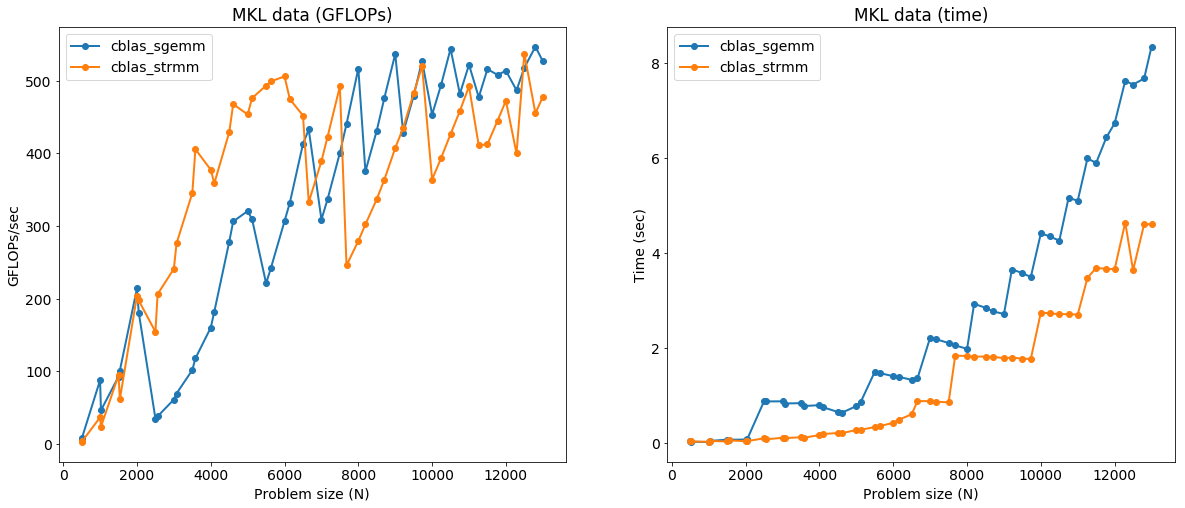

In [5]:
M = load_mkl_data('../results/baseline.mkl*.json')

plt.figure(figsize=(20,8))
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plot_mkl(M, title='MKL data (GFLOPs)')
plt.subplot(1, 2, 2)
plot_mkl(M, time=True, title='MKL data (time)')

plt.show()

In [6]:
perm_map = {'ijk':1, 'ikj':2, 'jik':3, 'jki':4, 'kij':5, 'kji':6}

def load_our_data(results_file_glob):
    data = []
    for filename in glob(results_file_glob):
        with open(filename, 'r') as f:
            data += json.load(f)
    data = [o for o in data if len(o['times'])!=0 and not o['error']]    
    X, Y = [], []
    for x in data:
        N = x['N']
        permutation = perm_map[x['permutation']] if x['permutation'] else None
        tiled = 1 if x['tiled'] else 0
        TS = x['TS']
        parallel = 1 if x['parallel'] else 0
        loop_parallelized = 0 if x['loop_parallelized']=='I' else 1
        num_threads = x['num_threads']
        blocks_per_side = x['blocks_per_side'] if 'blocks_per_side' in x else None
        block_size = x['block_size'] if 'block_size' in x else None
        time = np.mean(sorted(x['times'])[1:-1])
        X.append([N, permutation, tiled, TS, parallel, loop_parallelized, num_threads, blocks_per_side, block_size])
        Y.append(time)
    X = np.array(X)
    Y = np.array(Y)
    Y.shape = (Y.shape[0], 1)
    return np.hstack([X,Y])

def filter_dim(P, permutation=None, N=None, parallel=None, tiled=None, time=None, num_threads=None, loop_parallelized=None, TS=None):
    try:
        # [N, permutation, tiled, TS, parallel, loop_parallelized, num_threads, blocks_per_side, block_size]
        ret = P
        if N:
            ret = ret[np.where(ret[:,0]==N)]
        if permutation:
            ret = ret[np.where(ret[:,1]==perm_map[permutation])]
        if tiled != None:
            ret = ret[np.where(ret[:,2]==tiled)]
        if TS:
            ret = ret[np.where(ret[:,3]==TS)]
        if parallel != None:
            ret = ret[np.where(ret[:,4]==parallel)]
        if loop_parallelized:
            ret = ret[np.where(ret[:,5]==loop_parallelized)]
        if num_threads:
            ret = ret[np.where(ret[:,6]==num_threads)]
        if time:
            if len(ret) == 0:
                ret = []
            else:
                ret = ret[np.where(ret[:,9]==np.min(ret[:,9]))] 
    except:
        print('filter_exception:')
        print('P.shape', P.shape)
        print(P)
        print('ret.shape', ret.shape)
        print(ret)
    return ret

def plot_ours(P, time=True, gflops=False, tiled=0, permutation=None, num_threads=None, title=None, parallel=0, loop_parallelized=None, legend=True, ymax=None, values_only=False):   
    if gflops:
        time = False
    ret = []
    def inner(P, time=True, gflops=False, tiled=0, permutation=None, num_threads=None, title=None, parallel=0, loop_parallelized=None, TS=None):
        for perm in perm_map.keys():
            if permutation and perm != permutation:
                continue
            p = filter_dim(P, permutation=perm)
            X, Y = [], []
            for N in np.unique(P[:,0]):
                t = filter_dim(p, N=N, tiled=tiled, parallel=parallel, loop_parallelized=loop_parallelized, num_threads=num_threads, TS=TS, time=True)
                if len(t) == 0:
                    continue
                t = t[0][9]
                gflops = calc_gflops(N, t, 'tt')
                X.append(N)
                Y.append(t if time else gflops)
            if values_only:
                ret.append((TS,X,Y))
            else:
                plt.plot(X, Y, 'o-', linewidth=2, label = perm.upper() if not TS else 'TS={}'.format(TS))
            
    
    if tiled:
        p = filter_dim(P, tiled=1)
        for TS in np.unique(p[:,3]):
            inner(P, time, gflops, tiled, permutation, num_threads, title, parallel, loop_parallelized, TS)
    else:
        inner(P, time, gflops, tiled, permutation, num_threads, title, parallel, loop_parallelized)
        

    if not values_only:
        if title:
            plt.title(title)
        plt.xlabel('Problem size (N)')
        plt.ylabel('Time (sec)' if time else 'GFLOPs/sec')
        if ymax:
            plt.ylim(0, ymax)
        if legend:
            plt.legend()
    else:
        return ret
    

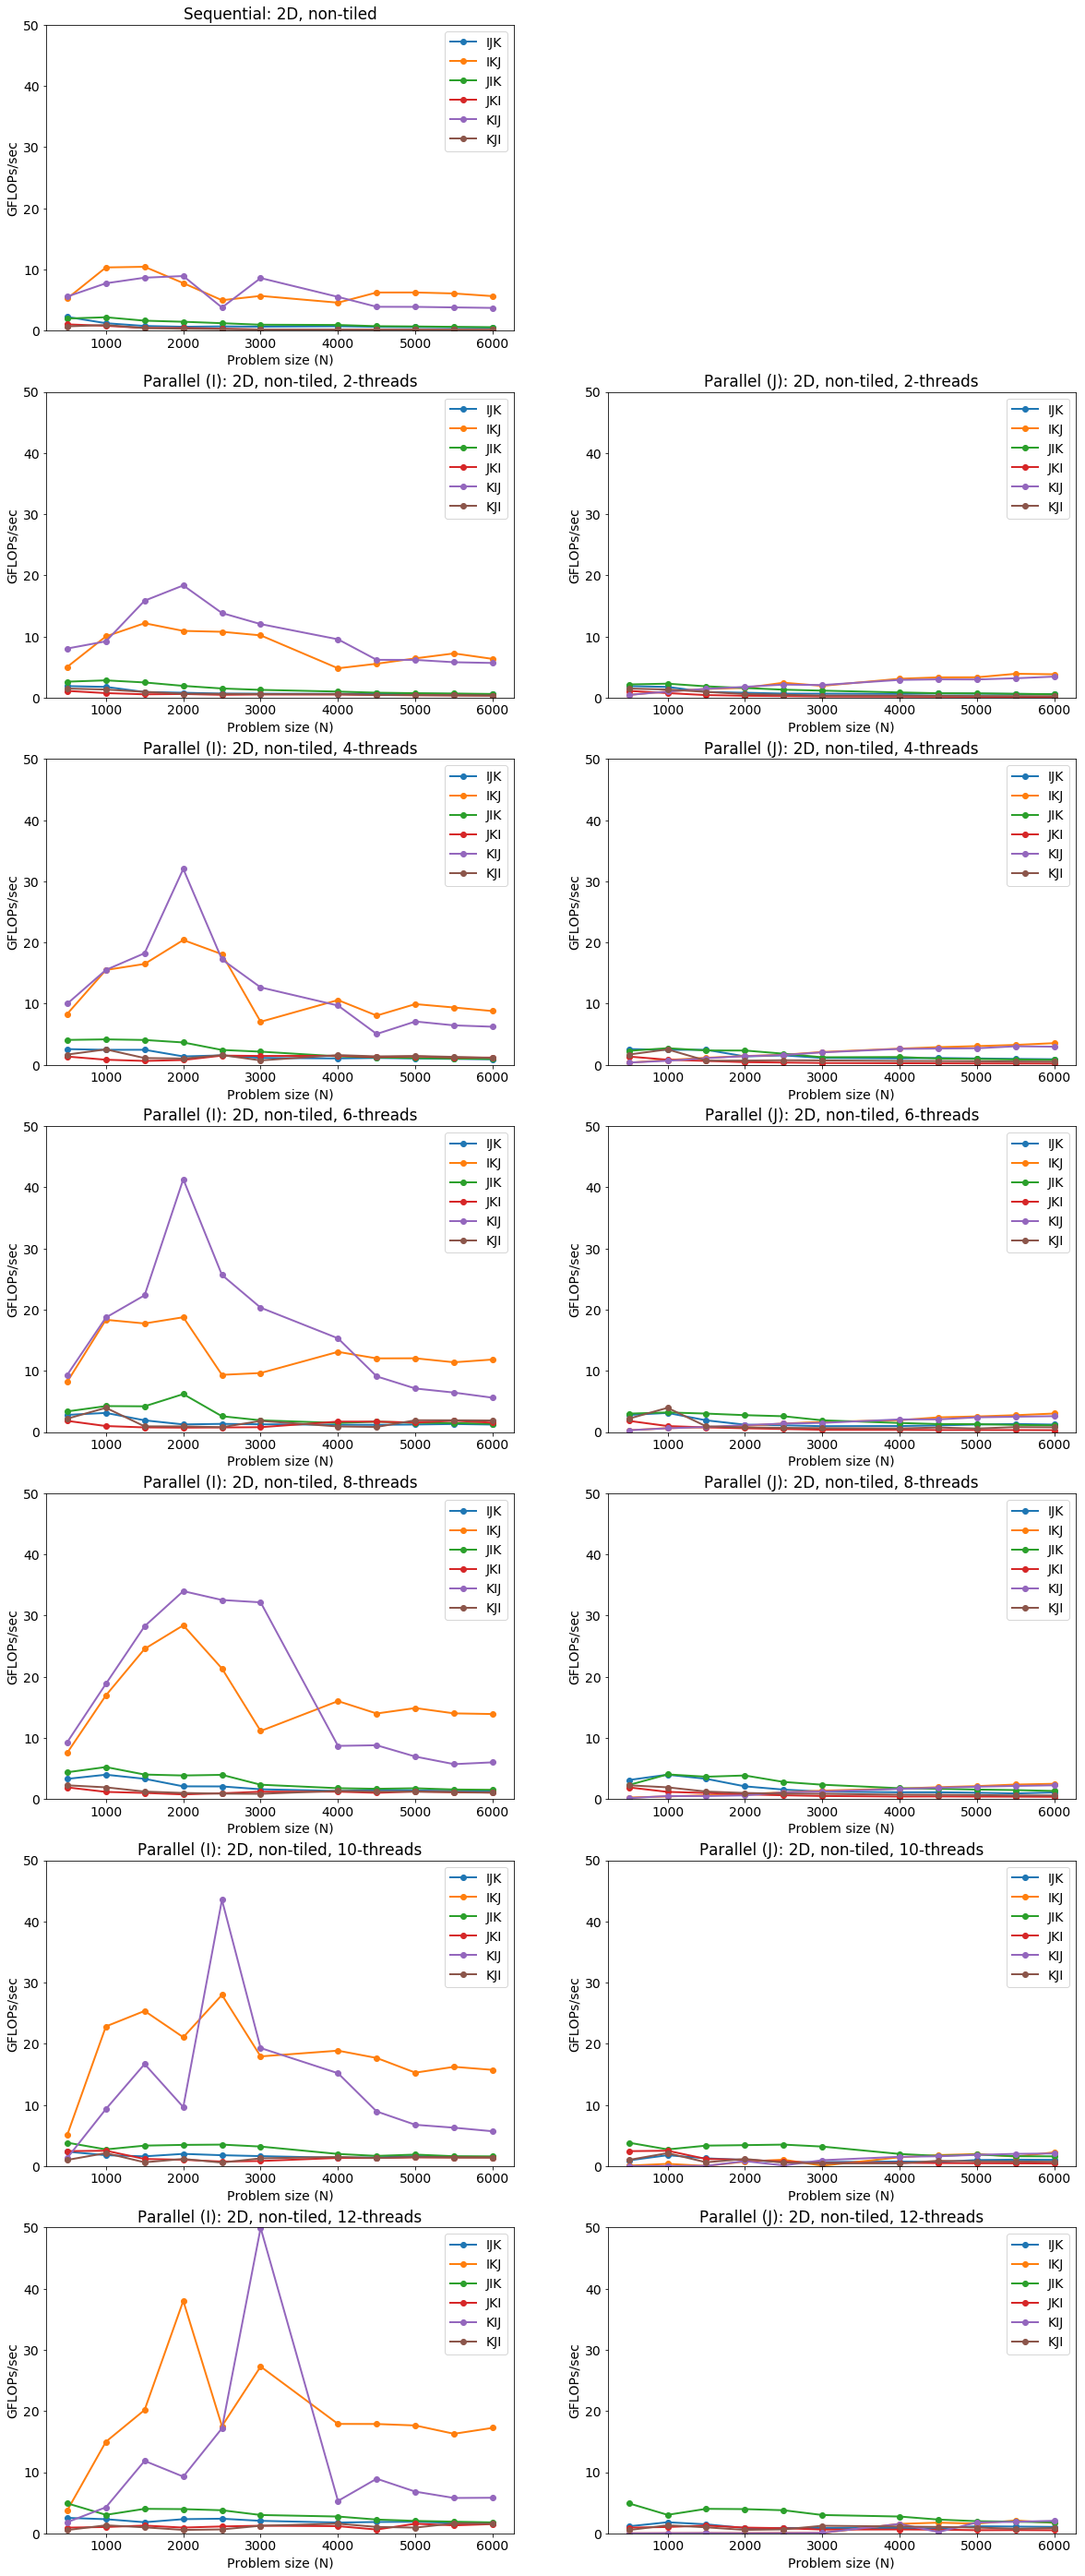

In [7]:
P = load_our_data('../results/2D.N*.json')
ON = True
ymax = 50

if ON:
    plt.figure(figsize=(20,50))
    plt.subplot(7,2,1)
    plot_ours(P, parallel=0, gflops=True, title='Sequential: 2D, non-tiled', ymax=ymax)
    for i, n in enumerate(range(2,14,2)):
        plt.subplot(7,2,1+n)
        plot_ours(P, parallel=1, gflops=True, num_threads=n, loop_parallelized=0, title='Parallel (I): 2D, non-tiled, {}-threads'.format(n), ymax=ymax)
        plt.subplot(7,2,1+n+1)
        plot_ours(P, parallel=1, gflops=True, num_threads=n, loop_parallelized=1, title='Parallel (J): 2D, non-tiled, {}-threads'.format(n), ymax=ymax)
    plt.show()

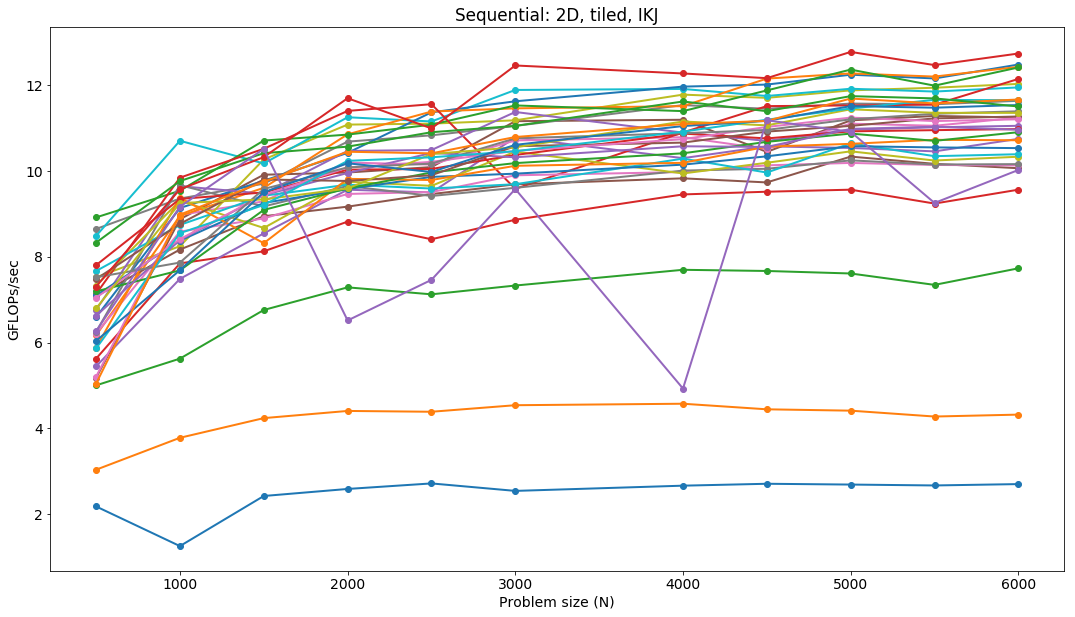

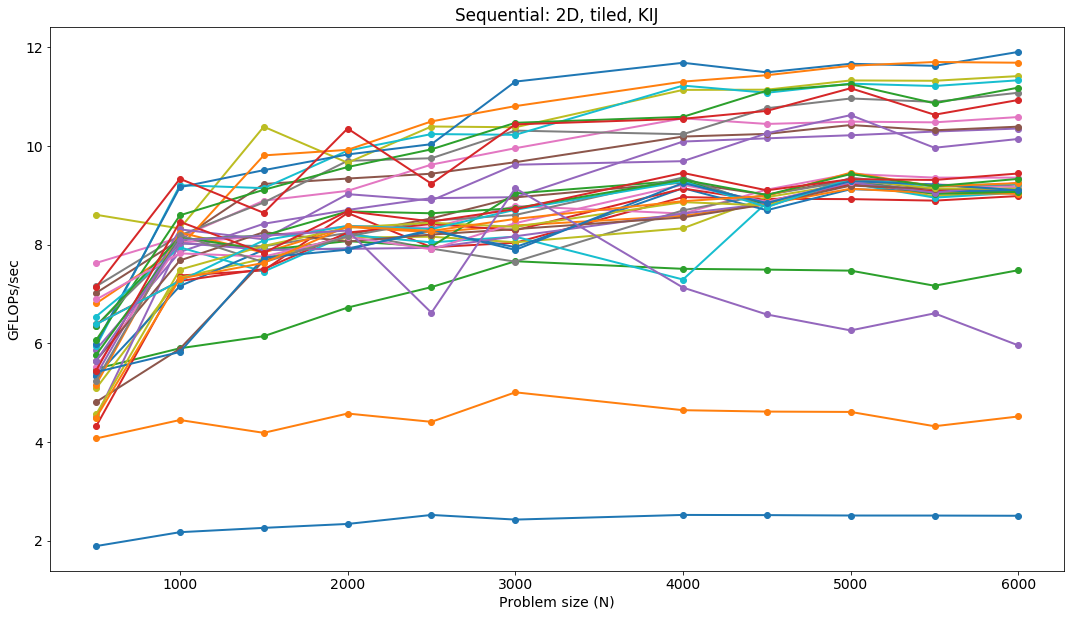

In [8]:
P = load_our_data('../results/2D.N*.json')

for perm in ['ikj', 'kij']:
    plt.figure(figsize=(40,10))
    plt.rcParams.update({'font.size': 14})
    plt.subplot(1,2,1)
    plot_ours(P, parallel=0, tiled=True, gflops=True, permutation=perm, title='Sequential: 2D, tiled, {}'.format(perm.upper()), legend=False)
plt.show()

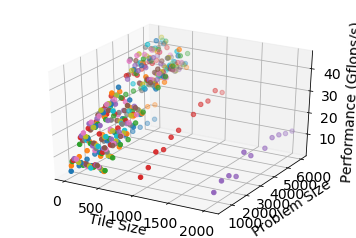

In [26]:
from mpl_toolkits.mplot3d import Axes3D
values = plot_ours(P, parallel=1, loop_parallelized=0, tiled=True, gflops=True, permutation='ikj', title='Parallel (I): 2D, tiled, {}'.format(perm.upper()), legend=False, values_only=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, TS in enumerate([v[0] for v in values]):
    xs = values[i][0]
    ys = values[i][1]
    zs = values[i][2]
    ax.scatter(xs, ys, zs)
    ax.set_xlabel('Tile Size')
    ax.set_ylabel('Problem Size')
    ax.set_zlabel('Performance (Gflops/s)')
    
plt.show()